In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from math import sin, cos
from PIL import ImageDraw, Image
import cv2

In [2]:
train = pd.read_csv('/kaggle/input/pku-autonomous-driving/train.csv')

#Intrinsic Camera Matrix
k = np.array([[2304.5479, 0, 1686.2379],       
              [0, 2305.8757, 1354.9849],
              [0, 0, 1]], dtype = np.float32)

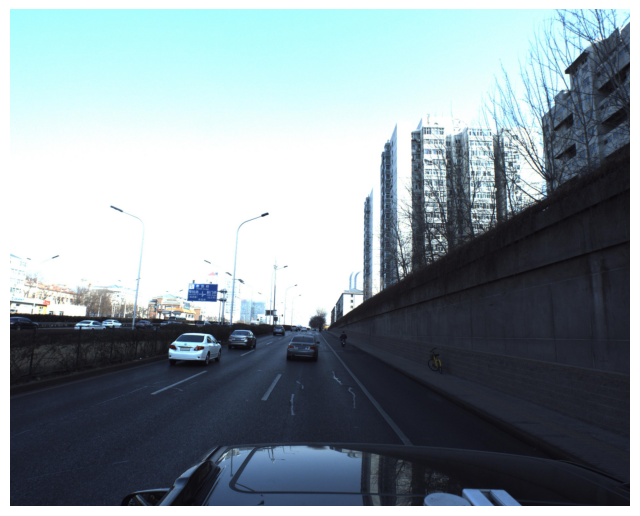

In [3]:
plt.rcParams['axes.grid'] = False
img_name = train.loc[4002]['ImageId']
pred_string = train.loc[4002]['PredictionString']
fig, ax = plt.subplots(figsize = (8, 8))
img = load_img(f'/kaggle/input/pku-autonomous-driving/train_images/{img_name}.jpg')
imgg = load_img(f'/kaggle/input/pku-autonomous-driving/train_images/{img_name}.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
items = pred_string.split(' ') #splitting a string (pred_string) into a list of items
model_types, yaws, pitches, rolls, xs, ys, zs = [items[i::7] for i in range(7)]

In [5]:
def euler_to_rot(yaw, pitch, roll):
    y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    p = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    r = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(y, np.dot(p, r))

In [6]:
def draw_lines(image, points):
    color = (255, 0, 255)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 15)
    cv2.line(image, tuple(points[1][:2]), tuple(points[4][:2]), color, 15)
    cv2.line(image, tuple(points[1][:2]), tuple(points[5][:2]), color, 15)
    
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 15)
    cv2.line(image, tuple(points[2][:2]), tuple(points[6][:2]), color, 15)
    
    cv2.line(image, tuple(points[3][:2]), tuple(points[4][:2]), color, 15)
    cv2.line(image, tuple(points[3][:2]), tuple(points[7][:2]), color, 15)
    
    cv2.line(image, tuple(points[4][:2]), tuple(points[8][:2]), color, 15)
    
    cv2.line(image, tuple(points[5][:2]), tuple(points[8][:2]), color, 15)
    cv2.line(image, tuple(points[5][:2]), tuple(points[6][:2]), color, 15)
    
    cv2.line(image, tuple(points[6][:2]), tuple(points[7][:2]), color, 15)
    
    cv2.line(image, tuple(points[7][:2]), tuple(points[8][:2]), color, 15)
    return image

def draw_points(image, points):
    image = np.array(image)
    for (p_x, p_y, p_z) in points:
        #print(p_x, p_y, p_z)
        cv2.circle(image, (p_x, p_y), 5,  (255,0, 255),-1)
    return image    

In [7]:
def img_cor_2_world_cor():       # convert image coordinates into world coordinates
    x_img, y_img, z_img = img_cor_points[0]
    xc, yc, zc = x_img*z_img, y_img*z_img, z_img
    p_cam = np.array([xc, yc, zc])
    xw, yw, zw = np.dot(np.linalg.inv(k), p_cam)
    #print(xw, yw, zw)
    #print(x, y, z)

## 3D Bounding box

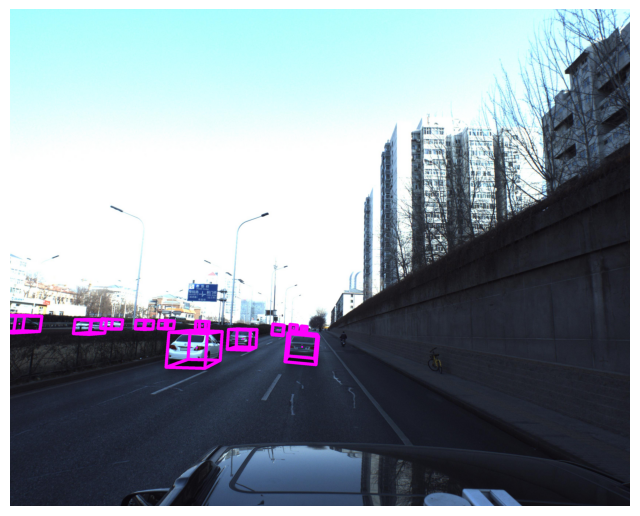

In [8]:
x_l = 0.9
y_l = 0.8
z_l = 2.0

for yaw, pitch, roll, x, y, z in zip(yaws, pitches, rolls, xs, ys, zs):
    yaw, pitch, roll, x, y, z = [float(x) for x in [yaw, pitch, roll, x, y, z]]
    yaw, pitch, roll = -pitch, -yaw, -roll
    rt = np.eye(4)
    t = np.array([x, y, z])
    rt[:3, 3] = t
    rt[:3, :3] = euler_to_rot(yaw, pitch, roll).T
    rt = rt[:3, :]
    p = np.array([[0, 0, 0, 1],
                  [x_l, y_l, -z_l, 1], 
                  [x_l, y_l, z_l, 1],
                  [-x_l, y_l, z_l, 1],
                  [-x_l, y_l, -z_l, 1],
                  [x_l, -y_l, -z_l, 1],
                  [x_l, -y_l, z_l, 1],
                  [-x_l, -y_l, z_l, 1],
                  [-x_l, -y_l, -z_l, 1]]).T
    img_cor_points = np.dot(k, np.dot(rt, p)).T
    img_cor_points[:, 0] /= img_cor_points[:, 2]
    img_cor_points[:, 1] /= img_cor_points[:, 2]
    img_cor_2_world_cor()
    img_cor_points = img_cor_points.astype(int)
    img = draw_points(img, img_cor_points)
    img = draw_lines(img, img_cor_points)
img = Image.fromarray(img)
plt.figure(figsize = (8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()
    

## 3D Modeling
      
 #####    ✨ Extract any model from car_models_json and apply, in this example I used                 dazhongmaiteng model.

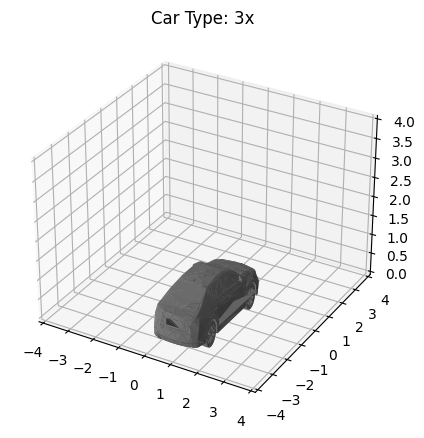

In [9]:
with open('/kaggle/input/pku-autonomous-driving/car_models_json/dazhongmaiteng.json') as json_file:
    data = json.load(json_file)
    vertices = np.array(data['vertices'])
    triangles = np.array(data['faces']) - 1
    plt.figure(figsize= (10, 5))
    ax = plt.axes(projection= '3d')
    ax.set_title('Car Type: '+ data['car_type'])
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_zlim([0, 4])
    ax.plot_trisurf(vertices[:, 0], vertices[:,2], triangles, -vertices[:,1],
                   shade=True, color='grey')

In [10]:
vertices[:, 1] = -vertices[:, 1]  # Flip the model to can apply it 

In [11]:
def draw_obj(image, vertices, triangles):
    for t in triangles:
        coord = np.array([vertices[t[0]][:2], vertices[t[1]][:2], vertices[t[2]][:2]], dtype=np.int32)
        cv2.polylines(image, np.int32([coord]), 1, (0,0,255))

## Augmented Reality 

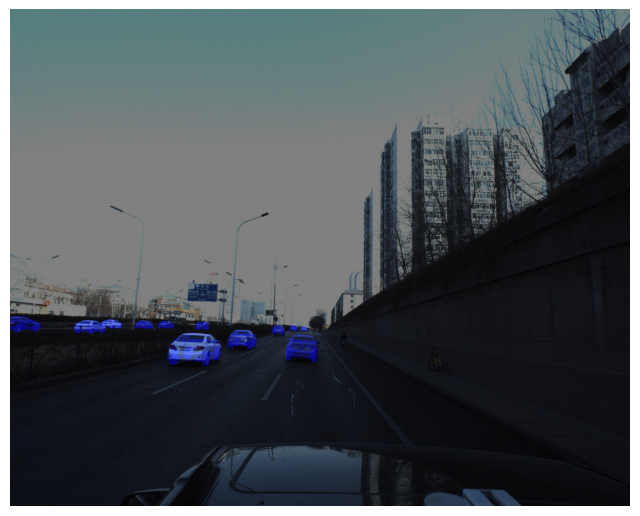

In [12]:
overlay = np.zeros_like(imgg)
for yaw, pitch, roll, x, y, z in zip(yaws, pitches, rolls, xs, ys, zs):
    yaw, pitch, roll, x, y, z = [float(x) for x in [yaw, pitch, roll, x, y, z]]
    yaw, pitch, roll = -pitch, -yaw, -roll
    Rt = np.eye(4)
    t = np.array([x, y, z])
    Rt[:3, 3] = t
    Rt[:3, :3] = euler_to_rot(yaw, pitch, roll).T
    Rt = Rt[:3, :]
    P = np.ones((vertices.shape[0],vertices.shape[1]+1))
    P[:, :-1] = vertices
    P = P.T
    img_cor_points = np.dot(k, np.dot(Rt, P))
    img_cor_points = img_cor_points.T
    img_cor_points[:, 0] /= img_cor_points[:, 2]
    img_cor_points[:, 1] /= img_cor_points[:, 2]
    draw_obj(overlay, img_cor_points, triangles)

alpha = .5
imgg = np.array(imgg)
cv2.addWeighted(overlay, alpha, imgg, 1 - alpha, 0, imgg)
plt.figure(figsize=(8,8))
plt.imshow(imgg);
plt.axis('off')
plt.show()

#### But take care, the output does not match all the types of cars for AR, it only matches the same car model. 